# Vehicle Detection Project

The goals / steps of this project are the following:

* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Settings

In [8]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = 32
hist_bins = 32

training_size = 500

figure_size = (16, 16)

### Imports

In [2]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle

from skimage.feature import hog
from tqdm import tqdm

### Functions

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,1),6) 
                
    return draw_img

### Initialization

In [9]:
car_images = []
non_car_images = []

#print('Reading test images...')
#test_images = []
#test_image_paths = glob.glob('test_images/*.jpg')
#for test_image_path in tqdm(test_image_paths):
#    img = mpimg.imread(test_image_path, format='JPG').astype(np.float32)/255
#    test_images.append(img)

print('Reading', training_size, 'random car images...')
car_image_paths = glob.glob('training_images\\cars\\*.png')
np.random.shuffle(car_image_paths)
for car_image_path in tqdm(car_image_paths[:training_size]):
    img = mpimg.imread(car_image_path, format='PNG')
    car_images.append(img)

print('Reading', training_size, 'random non-car images...')
non_car_image_paths = glob.glob('training_images\\non_cars\\*.png')
np.random.shuffle(non_car_image_paths)
for non_car_image_path in tqdm(non_car_image_paths[:training_size]):
    img = mpimg.imread(non_car_image_path, format='PNG')
    non_car_images.append(img)
    
print('Done.')


Reading 500 random car images...


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 55.92it/s]


Reading 500 random non-car images...


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 72.20it/s]


Done.


### Pipeline Step by Step

##### Histogram of Oriented Gradients (HOG) feature extraction

Getting HOG features for each car image...


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 471.11it/s]


Getting HOG features for each non-car image...


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 519.54it/s]


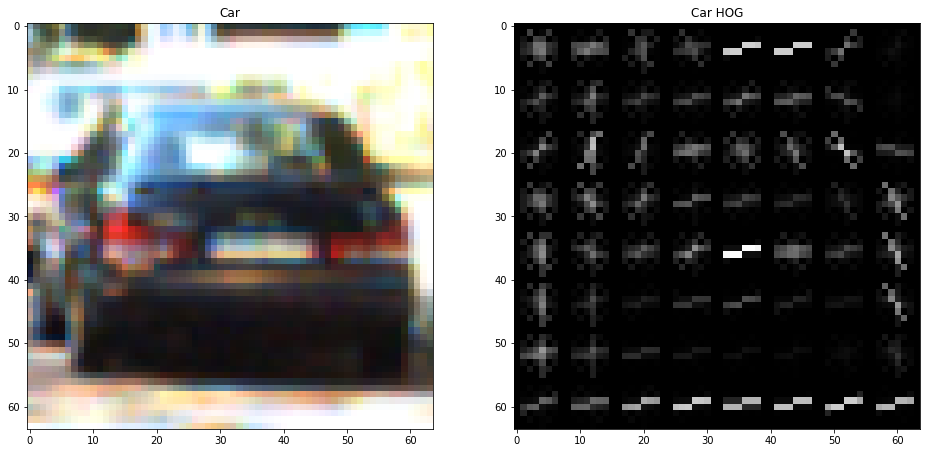

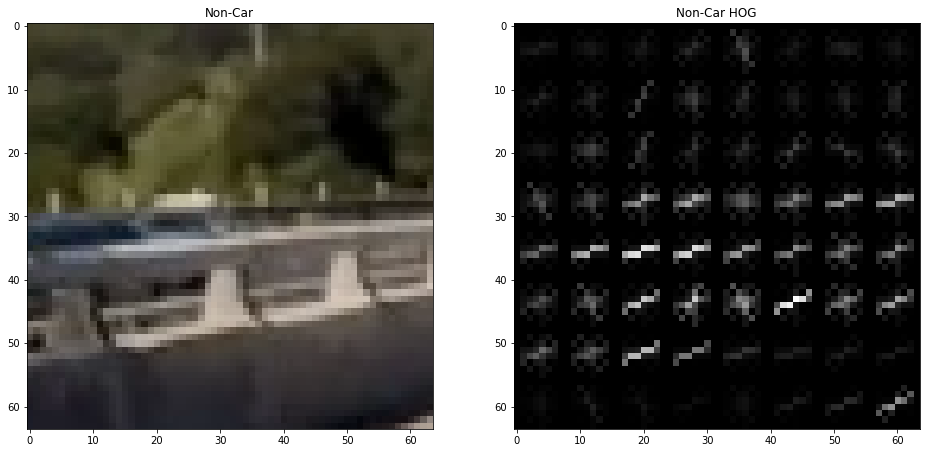

In [16]:
car_hog_features_list = []
non_car_hog_features_list = []

print('Getting HOG features for each car image...')
for img in tqdm(car_images):    
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    features = get_hog_features(gray_img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    car_hog_features_list.append(features)  

#Example - Car
f = plt.figure(figsize=figure_size)        
f.add_subplot(1,2,1)
plt.title('Car')
plt.imshow(car_images[-1])

_, hog_image = get_hog_features(gray_img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
f.add_subplot(1,2,2)
plt.title('Car HOG')
plt.imshow(hog_image, cmap='gray')

print('Getting HOG features for each non-car image...')
for img in tqdm(non_car_images):    
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    features = get_hog_features(gray_img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    non_car_hog_features_list.append(features)  

#Example - Non-Car
f = plt.figure(figsize=figure_size)        
f.add_subplot(1,2,1)
plt.title('Non-Car')
plt.imshow(non_car_images[-1])

_, hog_image = get_hog_features(gray_img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
f.add_subplot(1,2,2)
plt.title('Non-Car HOG')
plt.imshow(hog_image, cmap='gray')
    


##### Binned color spatial feature extraction

Getting binned spartial features for each car image...


100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 33190.14it/s]


Getting binned spartial features for each non-car image...


100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 38357.39it/s]


(0, 255)

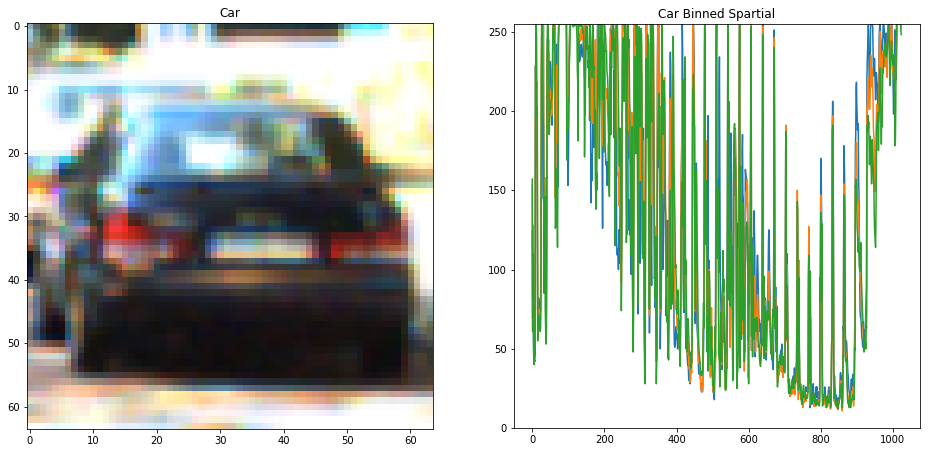

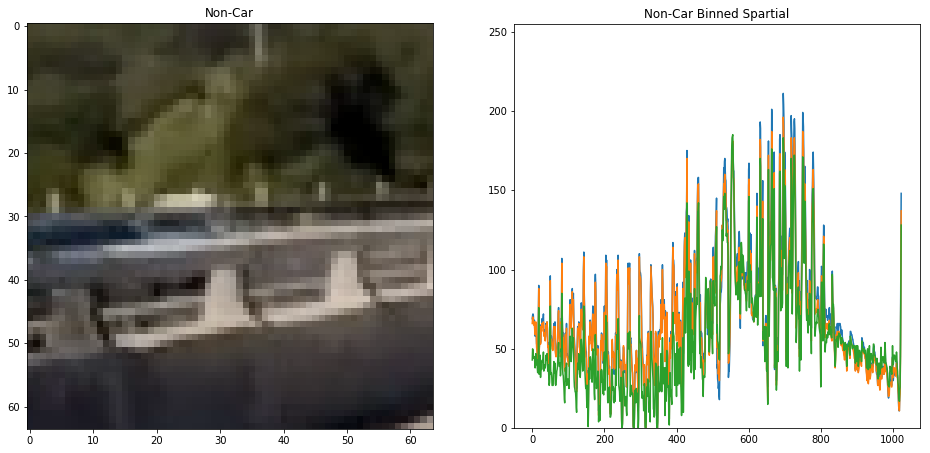

In [36]:
car_bin_features_list = []
non_car_bin_features_list = []

print('Getting binned spartial features for each car image...')
for img in tqdm(car_images): 
    features = bin_spatial(img, size=(spatial_size, spatial_size))    
    car_bin_features_list.append(features)

#Example - Car
f = plt.figure(figsize=figure_size)        
f.add_subplot(1,2,1)
plt.title('Car')
plt.imshow(car_images[-1])

ax = f.add_subplot(1,2,2)
ax.set_aspect(4.4)
plt.title('Car Binned Spartial')
plt.plot(features.reshape((-1, spatial_size ** 2)).T)
ax.set_ylim([0, 255])

print('Getting binned spartial features for each non-car image...')
for img in tqdm(non_car_images): 
    features = bin_spatial(img, size=(spatial_size, spatial_size))    
    non_car_bin_features_list.append(features)

#Example - Non-Car
f = plt.figure(figsize=figure_size)        
f.add_subplot(1,2,1)
plt.title('Non-Car')
plt.imshow(non_car_images[-1])

ax = f.add_subplot(1,2,2)
ax.set_aspect(4.4)
plt.title('Non-Car Binned Spartial')
plt.plot(features.reshape((-1, spatial_size ** 2)).T)
ax.set_ylim([0, 255])
    

##### Color histogram feature extraction